# Named Entity Recognition (NER)
El reconocimiento de entidades nombradas (NER), también llamado fragmentación de entidades o extracción de entidades, es un componente del procesamiento de lenguaje natural (PLN) que identifica categorías predefinidas de objetos en un cuerpo de texto.

Básicamente, el NER es el proceso de tomar una cadena de texto (es decir, una frase, un párrafo o un documento entero), e identificar y clasificar las entidades que se refieren a cada categoría.

## Bibliotecas

In [ ]:
#%pip install datasets
#%pip install transformers torch
#%pip install --upgrade "transformers[torch]" "accelerate>=0.26.0"
#%pip install langdetect
#%pip install huggingface_hub

In [ ]:
import pandas as pd
import re
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, AutoTokenizer, pipeline, DataCollatorForTokenClassification
from datasets import load_dataset, Dataset, concatenate_datasets
from huggingface_hub import login,  HfApi, upload_folder

In [3]:
df = pd.read_csv("protocolos_completo_limpios.csv")

## Paso 1. Identificar las entidades por "reconocer"
Pensamos que una de las estrategías a seguir para saber que entidades son las que va a reconocer el sistemta era tomar las palabras clave de los protocolos, por lo que hicimos lo siguiente:

`df = pd.read_csv("protocolos_completo_limpios.csv")`

`palabras_clave = (df['claves'].str.split(',').explode().str.strip().drop_duplicates())`

`palabras_clave.to_csv("palabras_clave.txt", index=False, header=False)`

Y luego limpiamos los puntos y puntuación (. , ; :) y convertimos a minúsculas las palabras clave, además establecimos la condición de que para ser candidata a ser una entidad por reconocer, la oración debía contener por lo menos 2 palabras.

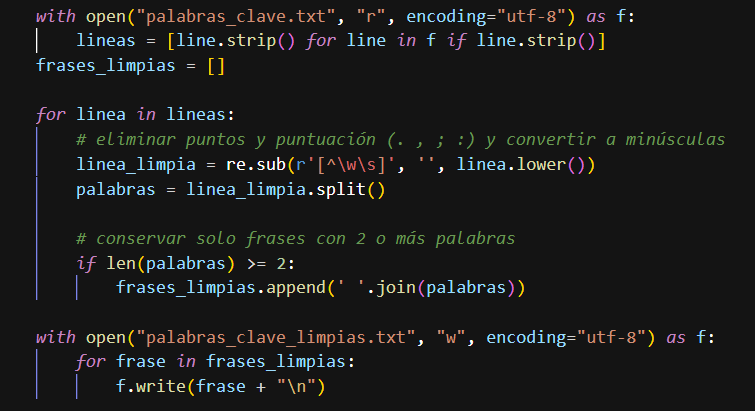

Luego de exportar las palabras clave a un txt, estas se limpiaron manualmente, eliminando frases o palabras que no fueran consideradas de interés, por ejemplo "mariposa monarca".

## Paso 2. Reconocer las entidades dentro de los protocolos

### Carga de palabras_clave_limpias.txt

In [4]:
with open("palabras_clave_limpias.txt", "r", encoding="utf-8") as f:
    frases_clave = [line.strip().lower() for line in f if line.strip()]
# dividimos cada frase en tokens, pero solo conservamos las que tienen al menos dos palabras
frases_clave_tokens = [frase.split() for frase in frases_clave if len(frase.split()) >= 2]

### Convertir el contenido de la columna a minusculas, eliminar signos de puntuacion como , . ;

In [7]:
def limpiar_columna_texto(df, columna):
    return df[columna].apply(lambda x: re.sub(r'[.,;]', '', str(x).lower()) if pd.notnull(x) else x)
titulos = limpiar_columna_texto(df, 'Titulo')
resumen = limpiar_columna_texto(df, 'resumen')
objetivos = limpiar_columna_texto(df, 'objetivos')
claves = limpiar_columna_texto(df, 'claves')
titulos.head(3)

0         laboratorio virtual de electrónica analógica
1    sistema de control automático para un invernad...
2    aplicación web de un pizarrón virtual con cola...
Name: Titulo, dtype: object

### Etiquetado de texto en formato BIO
El formato BIO sirve para etiquetar tokens en un texto y marcar cuáles forman parte de una entidad, donde:

| Etiqueta | Significado |
|----------|-------------|
| B-XXX    | Beginning: inicio de una entidad del tipo XXX |
| I-XXX    | Inside: continuación de la entidad del mismo tipo |
| O        | Outside: el token no pertenece a ninguna entidad |

Ejemplo: 
```bash
aplicación        B-TECH
web               I-TECH
de                O
un                O
pizarrón          O
virtual           O
```

Por lo tanto, se reconoce como una entidad `TECH` a "**aplicación web**".

* `TECH`: Se refiere a entidades con conceptos tecnológicos o técnicos.


In [8]:
# esta funcion recibe un texto y una lista de frases clave ya tokenizadas
# y asigna etiquetas tipo bio a los tokens que coincidan con alguna de esas frases

def etiquetar_texto_con_bio(texto, frases_clave_tokens):
    # se divide el texto en tokens individuales
    tokens = texto.strip().split()
    tokens_minusculas = [t.lower() for t in tokens]
    # se inicializa una lista de etiquetas con O's (sin entidad) para cada token
    etiquetas = ['O'] * len(tokens)
    # se recorre cada frase clave ya tokenizada
    for frase_tokens in frases_clave_tokens:
        n = len(frase_tokens)  # largo de la frase
        # se recorre el texto buscando coincidencias exactas con las etiquetas 
        for i in range(len(tokens) - n + 1):
            if tokens_minusculas[i:i + n] == frase_tokens:
                etiquetas[i] = 'B-TECH'  # primera palabra de la entidad
                for j in range(1, n):
                    etiquetas[i + j] = 'I-TECH'  # resto de la entidad

    # se devuelven los tokens junto con sus etiquetas asignadas
    return list(zip(tokens, etiquetas))

In [9]:
# esta funcion procesa una columna de texto ya limpia y guarda las etiquetas en formato bio
def procesar_columna(nombre_columna, lineas):
    # se define el nombre del archivo de salida usando el nombre de la columna
    archivo_salida = f"BIO_{nombre_columna.lower()}.txt"
    with open(archivo_salida, "w", encoding="utf-8") as f:

        # se recorre cada texto 
        for texto in lineas:
            # se obtiene la lista de tokens y etiquetas usando la funcion de etiquetado previa
            resultado_bio = etiquetar_texto_con_bio(texto, frases_clave_tokens)
            # se escribe cada token y su etiqueta en una misma linea
            for token, etiqueta in resultado_bio:
                f.write(f"{token} {etiqueta}\n")
            f.write("\n")


In [8]:
procesar_columna("Titulo", titulos)
procesar_columna("Resumen", resumen)
procesar_columna("Objetivos", objetivos)
procesar_columna("claves", claves)

## Paso 3. Pasar las etiquetas al modelo para hacer fine tuning

In [10]:
# definimos la lista de etiquetas que se usaran para el etiquetado bio
lista_etiquetas = ["O", "B-TECH", "I-TECH"]
# creamos un diccionario que asigna un id numerico a cada etiqueta
etiqueta_a_id = {etiqueta: i for i, etiqueta in enumerate(lista_etiquetas)}
# creamos un diccionario inverso que permite obtener la etiqueta a partir de su id
id_a_etiqueta = {i: etiqueta for etiqueta, i in etiqueta_a_id.items()}

In [12]:
# esta funcion lee un archivo en formato bio y convierte su contenido en una lista de registros etiquetados
def leer_bio_txt(ruta):
    ejemplos = []          
    tokens = []            
    etiquetas = []         

    with open(ruta, encoding="utf-8") as f:
        for linea in f:
            linea = linea.strip()

            # si la linea esta vacia, significa que termina un registro
            if not linea:
                if tokens:
                    ejemplos.append({"tokens": tokens, "ner_tags": etiquetas})
                    tokens = []
                    etiquetas = []
            else:
                # si la linea contiene texto, se separa el token de su etiqueta
                token, etiqueta = linea.split()
                tokens.append(token)
                etiquetas.append(etiqueta)

    # si quedan tokens pendientes al final del archivo, se agrega el ultimo registro
    if tokens:
        ejemplos.append({"tokens": tokens, "ner_tags": etiquetas})
    return ejemplos

In [13]:
dataset = (
    leer_bio_txt("BIO_titulo.txt") +
    leer_bio_txt("BIO_objetivos.txt") +
    leer_bio_txt("BIO_resumen.txt") +
    leer_bio_txt("BIO_claves.txt") +
    leer_bio_txt("claves_BIO_sin_acentos.txt")
)

## Modelos

### XML-ROBERTA-LARGE

In [ ]:
ds = Dataset.from_list(dataset)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True,
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()  
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

ds_tokenized = ds.map(tokenize_and_align_labels, batched=False)

#### Fine Tuning con las etiquetas creadas

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-large",
    num_labels=len(lista_etiquetas),
    id2label=id_a_etiqueta,
    label2id=etiqueta_a_id
)

training_args = TrainingArguments(
    output_dir="./ner_xlm_roberta",
    do_train=True,
    do_eval=False, 
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized,
    tokenizer=tokenizer
)

trainer.train()

#### Uso del modelo entrenado

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ner_xlm_roberta_tech")
modelo = AutoModelForTokenClassification.from_pretrained("ner_xlm_roberta_tech")
ner_pipeline = pipeline("ner", model=modelo, tokenizer=tokenizer, aggregation_strategy="simple")
texto = "El proyecto de bases de datos fue desarrollado por los estudiantes, ademas usaron redes neuronales y algo de visión por computadora y Gabriel García Márquez era buen escritor"
resultados = ner_pipeline(texto)

for r in resultados:
    print(f"Entidad: {r['word']} - Tipo: {r['entity_group']} - Score: {r['score']:.3f}")

Device set to use cpu


Entidad: bases de datos - Tipo: TECH - Score: 1.000
Entidad: redes neuronales - Tipo: TECH - Score: 0.999
Entidad: visión por computadora - Tipo: TECH - Score: 1.000


No reconoce a Gabriel como una persona cuando otros modelos que si...

## mrm8488-bert

In [56]:
# prueba rapida de como funciona el modelo mrm8488/bert-spanish-cased-finetuned-ner
model_name = "mrm8488/bert-spanish-cased-finetuned-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
modelo = AutoModelForTokenClassification.from_pretrained(model_name)
ner_pipeline = pipeline("ner", model=modelo, tokenizer=tokenizer, aggregation_strategy="simple")  
texto = "Gabriel García Márquez nació en Aracataca y escribió Cien años de soledad."

entidades = ner_pipeline(texto)
for entidad in entidades:
    print(f"{entidad['word']:30} -> {entidad['entity_group']} (score={entidad['score']:.2f})")

Some weights of the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Gabriel García Márquez         -> PER (score=1.00)
Aracataca                      -> LOC (score=0.93)
Cien años de soledad           -> MISC (score=1.00)


In [14]:
# cargamos el dataset conll2002 en español
dataset_conll = load_dataset("conll2002", "es", trust_remote_code=True)
etiquetas_originales = dataset_conll["train"].features["ner_tags"].feature.names # se obtienen las etiquetas del dataset (tipo BIO: PER, ORG, LOC)
etiquetas_nuevas = ["B-TECH", "I-TECH"] # etiquetas definidas nuevas
lista_etiquetas = etiquetas_originales.copy()

# agregamos nuestras nuevas etiquetas
for etiqueta in etiquetas_nuevas:
    if etiqueta not in lista_etiquetas:
        lista_etiquetas.append(etiqueta)

# mapeo de cada etiqueta a un id numerico
etiqueta_a_id = {etiqueta: i for i, etiqueta in enumerate(lista_etiquetas)}
id_a_etiqueta = {i: etiqueta for etiqueta, i in etiqueta_a_id.items()}

# Volvemos a cargar el dataset original (nota: esto no incluye las nuevas etiquetas agregadas)
dataset_conll = load_dataset("conll2002", "es", trust_remote_code=True)

In [15]:
# Esta funcion convierte las etiquetas tipo texto (como "B-TECH", "O", "I-LOC") 
# a sus identificadores numericos segun el diccionario label_to_id.
# Esto se hace porque los modelos de entrenamiento trabajan con IDs numericos y no con texto.

def convertir_etiquetas_a_ids(dataset, etiqueta_a_id):
    return [
        {
            "tokens": ejemplo["tokens"],
            "ner_tags": [etiqueta_a_id[etiqueta] for etiqueta in ejemplo["ner_tags"]]
        }
        for ejemplo in dataset
    ]

In [16]:
dataset_convertido = convertir_etiquetas_a_ids(dataset, etiqueta_a_id)
ds = Dataset.from_list(dataset_convertido)

In [17]:
# Convertimos los ejemplos del dataset CONLL a diccionarios planos
# esto se hace para que las etiquetas ner_tags sean enteros y poder combinar este dataset con otros que ya usan enteros normales,
# como el dataset creado

conll_plano = [
    {
        "tokens": ejemplo["tokens"],
        "ner_tags": [int(etiqueta) for etiqueta in ejemplo["ner_tags"]]
    }
    for ejemplo in dataset_conll["train"]
]

# Creamos un nuevo dataset a partir de los diccionarios planos
dataset_conll_plano = Dataset.from_list(conll_plano)

In [ ]:
print(ds.features)
print(dataset_conll_plano.features)

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [18]:
dataset_combinado = concatenate_datasets([dataset_conll_plano, ds])

#### Fine Tuning con las etiquetas creadas

In [19]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-spanish-cased-finetuned-ner")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128  
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # Repite la etiqueta si se repite subtoken (puedes usar -100 si quieres ignorarlos)
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [20]:
tokenized_dataset = dataset_combinado.map(tokenize_and_align_labels, batched=True)
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

Map: 100%|██████████| 13254/13254 [00:01<00:00, 7950.81 examples/s]


## Subir el dataset a Hugging Face para usos posteriores

In [21]:
dataset_combinado.save_to_disk("ner_tech_dataset_bio")

Saving the dataset (1/1 shards): 100%|██████████| 13254/13254 [00:00<00:00, 1208953.42 examples/s]


In [ ]:
# se crea el repositorio en Hugging Face para guardar el dataset
api = HfApi()
api.create_repo(
    repo_id="iEsmeralda/ner_tech_dataset_bio",  
    repo_type="dataset",
    private=False  
)

In [ ]:
upload_folder(
    folder_path="ner_tech_dataset_bio",
    repo_id="iEsmeralda/ner_tech_dataset_bio", 
    repo_type="dataset",
    path_in_repo=".",
    token=""
)

data-00000-of-00001.arrow: 100%|██████████| 8.50M/8.50M [00:01<00:00, 8.28MB/s]


CommitInfo(commit_url='https://huggingface.co/datasets/iEsmeralda/ner_tech_dataset_bio/commit/1e9c4ff1358d7cd27d321109263745292cd61f3c', commit_message='Upload folder using huggingface_hub', commit_description='', oid='1e9c4ff1358d7cd27d321109263745292cd61f3c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/iEsmeralda/ner_tech_dataset_bio', endpoint='https://huggingface.co', repo_type='dataset', repo_id='iEsmeralda/ner_tech_dataset_bio'), pr_revision=None, pr_num=None)

## Carga de dataset desde Hugging Face

In [ ]:
ds = load_dataset("iEsmeralda/ner_tech_dataset_bio")

In [24]:
model = AutoModelForTokenClassification.from_pretrained(
    "mrm8488/bert-spanish-cased-finetuned-ner",
    num_labels=len(lista_etiquetas),
    id2label=id_a_etiqueta,
    label2id=etiqueta_a_id,
    ignore_mismatched_sizes=True
)

Some weights of the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated

In [25]:
training_args = TrainingArguments(
    output_dir="./mrm8488-finetuned-ner-tech",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3
)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()

## Guardado de modelo

In [27]:
trainer.save_model("./mrm8488-finetuned-ner-tech")
tokenizer.save_pretrained("./mrm8488-finetuned-ner-tech")

('./mrm8488-finetuned-ner-tech\\tokenizer_config.json',
 './mrm8488-finetuned-ner-tech\\special_tokens_map.json',
 './mrm8488-finetuned-ner-tech\\vocab.txt',
 './mrm8488-finetuned-ner-tech\\added_tokens.json',
 './mrm8488-finetuned-ner-tech\\tokenizer.json')

In [30]:
# agrupar entidades consecutivas si son del mismo tipo y están juntas
def agrupar_entidades_consecutivas(entidades):
    if not entidades:
        return []

    entidades_agrupadas = []
    entidad_actual = entidades[0].copy()

    for i in range(1, len(entidades)):
        entidad = entidades[i]

        # Si la entidad es del mismo tipo y esta justo despues de la anterior, entonces:
        if entidad["entity_group"] == entidad_actual["entity_group"] and entidad["start"] == entidad_actual["end"] + 1:
            # Se concatena la palabra y se actualiza el rango y se toma un score promedio de ambas
            entidad_actual["word"] += " " + entidad["word"]
            entidad_actual["end"] = entidad["end"]
            entidad_actual["score"] = (entidad_actual["score"] + entidad["score"]) / 2
        else:
            entidades_agrupadas.append(entidad_actual)
            entidad_actual = entidad.copy()

    entidades_agrupadas.append(entidad_actual)
    return entidades_agrupadas

#### Uso del modelo entrenado

In [ ]:
modelo = AutoModelForTokenClassification.from_pretrained("mrm8488-finetuned-ner-tech")
tokenizer = AutoTokenizer.from_pretrained("mrm8488-finetuned-ner-tech")
ner_pipeline = pipeline("ner", model=modelo, tokenizer=tokenizer, aggregation_strategy="simple")
texto = "El proyecto de redes neuronales y algo de visión por computadora y Gabriel García Márquez era buen escritor y además quiero revisar si México aparece como una etiqueta de procesamiento de lenguaje natural, pero tambien deberiamos revisar si estructura de datos es una etiqueta válida o es mejor conocida estructuras de datos"
resultados = ner_pipeline(texto)
entidades_agrupadas = agrupar_entidades_consecutivas(resultados)

for e in entidades_agrupadas:
    print(f"Entidad: {e['word']} - Tipo: {e['entity_group']} - Score: {e['score']:.3f}")

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Entidad: redes neuronales - Tipo: TECH - Score: 0.999
Entidad: visión por computadora - Tipo: TECH - Score: 0.998
Entidad: Gabriel García Márquez - Tipo: PER - Score: 0.999
Entidad: México - Tipo: LOC - Score: 0.875
Entidad: procesamiento de lenguaje natural - Tipo: TECH - Score: 0.999
Entidad: estructura de datos - Tipo: TECH - Score: 0.978
Entidad: estructuras de datos - Tipo: TECH - Score: 0.990


## Subir los modelos a Hugging Face para usos posteriores

In [ ]:
login("token") 
model.push_to_hub("mrm8488-finetuned-ner-tech", safe_serialization=False)
tokenizer.push_to_hub("mrm8488-finetuned-ner-tech")

In [ ]:
model.push_to_hub("ner_xlm_roberta_tech", safe_serialization=False)
tokenizer.push_to_hub("ner_xlm_roberta_tech")

## Carga de modelo desde Hugging Face

In [ ]:
modelo = AutoModelForTokenClassification.from_pretrained("iEsmeralda/mrm8488-finetuned-ner-tech")
tokenizer = AutoTokenizer.from_pretrained("iEsmeralda/mrm8488-finetuned-ner-tech")
ner_pipeline = pipeline("ner", model=modelo, tokenizer=tokenizer, aggregation_strategy="simple")


texto = "El proyecto de redes neuronales y algo de visión por computadora y Gabriel García Márquez era buen escritor nacido en Colombia y procesamiento de lenguaje natural"
entidades = ner_pipeline(texto)
entidades_agrupadas = agrupar_entidades_consecutivas(entidades)

for e in entidades_agrupadas:
    print(f"Entidad: {e['word']} - Tipo: {e['entity_group']} - Score: {e['score']:.3f}")

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Entidad: redes neuronales - Tipo: TECH - Score: 0.999
Entidad: visión por computadora - Tipo: TECH - Score: 0.998
Entidad: Gabriel García Márquez - Tipo: PER - Score: 0.999
Entidad: Colombia - Tipo: LOC - Score: 0.998
Entidad: procesamiento de lenguaje natural - Tipo: TECH - Score: 0.917


## Prueba con dataset de protocolos

In [ ]:
texto = df["objetivos"].iloc[13]
print(texto)
entidades = ner_pipeline(texto)
entidades_agrupadas = agrupar_entidades_consecutivas(entidades)

for e in entidades_agrupadas:
    print(f"Entidad: {e['word']} - Tipo: {e['entity_group']} - Score: {e['score']:.3f}")

continuación, se enuncia el objetivo general de este Trabajo Terminal. Implementar un sistema de software para evaluar programas orientados a objetos y estructurados, escritos en los lenguajes de programación Java y C, respectivamente, usando métricas de software para código fuente. Objetivos específicos Una vez establecido el objetivo general, es necesario fragmentarlo en objetivos específicos para tener claro los puntos que se deben desarrollar para alcanzarlo. A continuación, se listan los objetivos específicos de este trabajo.       Implementar un subsistema gestor de usuarios. Desarrollar un subsistema gestor de archivos. Implementar un subsistema de análisis de métricas de programación orientada a objetos. Implementar un subsistema de análisis de métricas de programación estructurada. Desarrollar un subsistema de despliegue y comparación de resultados.
Entidad: Trabajo Terminal - Tipo: MISC - Score: 0.976
Entidad: programación orientada a objetos - Tipo: TECH - Score: 0.908
Entid